In [17]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as matplotlibPolygon
from multiprocessing import Pool, cpu_count
from shapely.affinity import scale
from shapely.strtree import STRtree
from scipy.spatial import ConvexHull

import json
from rtree import index

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [18]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered_new/"
polygon_dir  = "/data/projects/robin/segmentation/output-new-seg/segmentation_polygons.json"

with open(polygon_dir, 'r') as file:
    polygon_dict = json.load(file)

adata_with_domain = sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")

In [19]:
cell_names = [str(polygon_dict['geometries'][i]['cell']) for i in range(len(polygon_dict['geometries']))]
cell_coordinates = [polygon_dict['geometries'][i]['coordinates'][0] for i in range(len(polygon_dict['geometries']))]
cell_names = np.array(cell_names)
df_polygon = pd.DataFrame({
    'names' : cell_names,
    'coords' : cell_coordinates})
df_polygon.index = df_polygon['names']
df_polygon

,names,coords
names,,
185983,185983,"[[3714.5618, 20479.88], [3714.3374, 20482.264]..."
371966,371966,"[[7231.8833, 3040.58], [7232.0537, 3039.7822],..."
221120,221120,"[[7118.4053, 19706.914], [7115.494, 19704.934]..."
92533,92533,"[[1470.7107, 14148.667], [1470.7705, 14150.08]..."
76914,76914,"[[2689.5303, 12016.144], [2688.5042, 12016.396..."
...,...,...
300650,300650,"[[1215.121, 13696.862], [1213.2627, 13699.764]..."
150325,150325,"[[6032.6353, 14348.5], [6033.725, 14348.425], ..."
336545,336545,"[[7494.6553, 8513.94], [7494.7266, 8513.655], ..."


In [38]:
sample = 'X3'

# Read anndata
adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')

# Add "is_in_polygon" col. to the data
is_in_polygon = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'is_in_polygon']
nichepca_glom_no = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'nichepca_glom_no']
polygon_id = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'polygon_flags']
celltype_l1_prob = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'celltype_l1_prob']

adata.obs['is_in_polygon'] = list(is_in_polygon)
adata.obs['nichepca_glom_no'] = list(nichepca_glom_no)
adata.obs['polygon_id'] = list(polygon_id)
adata.obs['celltype_l1_prob'] = list(celltype_l1_prob)

# Restrict anndata to PECs in polygon
adata = adata[adata.obs['is_in_polygon']]
# adata = adata[adata.obs['celltype_l1'] == 'PEC']

print(adata.shape)

(5017, 480)


In [39]:
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,n_genes,celltype_l1,celltype_l1_codes,celltype_l1_prob,Slide_ID,sample,label,is_in_polygon,nichepca_glom_no,polygon_id
cell_CR9fbacb852-120237,6661.259189,11947.209556,26.568151,2,9,1.3890,2.982,6.479,0.9882,0.9822,...,8,Mono,26,0.798558,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120332,6663.345219,11957.900920,28.907549,4,200,1.7010,2.083,117.600,0.9981,0.9704,...,100,FIB,6,0.998933,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120344,6672.328824,11956.891184,29.637057,4,144,1.4340,3.907,100.400,0.9976,0.9612,...,84,PEC,28,1.000000,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120347,6690.989373,11935.039441,30.859622,3,202,1.1790,1.467,171.300,0.9966,0.9192,...,45,podocyte,29,1.000000,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
cell_CR9fbacb852-120357,6697.359459,11927.989103,31.478945,4,63,1.0540,1.980,59.750,0.9929,0.9022,...,31,NKC/T,13,0.999084,0011186,x3,anca,True,0,0_0011186_ANCA_X3_slide2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-343675,7359.627888,13536.367956,26.355797,4,34,1.6140,5.497,21.060,0.9982,0.6735,...,5,pDC,27,0.344557,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-343916,6988.824929,13049.610391,26.573227,4,55,1.2830,2.150,42.860,0.9980,0.6495,...,6,Mono,26,0.943292,0011186,x3,anca,True,Other,1_0011186_ANCA_X3_slide2
cell_CR9fbacb852-344224,7179.321350,13431.796125,25.942680,4,8,2.3740,3.489,3.370,0.9969,0.8900,...,6,T,18,0.928944,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-344432,7320.050106,13519.232520,27.357920,4,50,1.9380,4.704,25.800,0.9978,0.6744,...,8,T,18,0.997094,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2


In [50]:
tokeep = []
id = '4_0011186_ANCA_X3_slide2'

for i in adata.obs['polygon_id']:
    if i == id:
        tokeep.append(True)
    elif len(i.split(',')) > 0:
        flag = 0
        for j in i.split(','):
            if j == id:
                flag = 1
                break
        if flag == 1:
            tokeep.append(True)
        else:
            tokeep.append(False)        
    else:
        tokeep.append(False)

np.sum(tokeep)

999

In [51]:
# adata = adata[adata.obs['nichepca_glom_no'] == '4']
# adata[adata.obs['polygon_id'] == '4_0011186_ANCA_X3_slide2']
adata = adata[tokeep]
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,n_genes,celltype_l1,celltype_l1_codes,celltype_l1_prob,Slide_ID,sample,label,is_in_polygon,nichepca_glom_no,polygon_id
cell_CR9fbacb852-153170,7092.386232,13428.500780,28.385260,3,41,0.9942,1.732,41.2400,0.9980,0.9527,...,24,EC,24,0.999669,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-153199,7120.733177,13398.874577,27.631408,1,97,0.7717,1.286,125.7000,0.9980,0.9468,...,41,PT,16,1.000000,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-153204,7088.793197,13433.869169,27.803531,3,68,1.2230,2.425,55.6200,0.9980,0.9379,...,36,DCT,3,0.999869,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-153313,7086.772676,13441.781944,27.622785,3,71,1.5570,1.489,45.5900,0.9982,0.8941,...,39,DCT,3,0.722969,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-153320,7132.766611,13394.213656,28.405226,1,128,0.8127,1.413,157.5000,0.9973,0.9294,...,52,PT,16,1.000000,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-343670,7311.355078,13528.870703,27.418549,4,37,2.4330,3.143,15.2100,0.9981,0.8011,...,14,FIB,6,1.000000,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-343674,7181.395633,13676.001500,25.757561,4,6,9.1170,25.260,0.6581,0.9954,0.9100,...,5,N,11,0.953635,0011186,x3,anca,True,Other,"4_0011186_ANCA_X3_slide2,6_0011186_ANCA_X3_slide2"
cell_CR9fbacb852-343675,7359.627888,13536.367956,26.355797,4,34,1.6140,5.497,21.0600,0.9982,0.6735,...,5,pDC,27,0.344557,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2
cell_CR9fbacb852-344224,7179.321350,13431.796125,25.942680,4,8,2.3740,3.489,3.3700,0.9969,0.8900,...,6,T,18,0.928944,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2


In [52]:
# Get the cell that exsit in both anndata and cell boundries
cell_name = [i.split('-')[1] for i in adata.obs.index]
adata.obs['cell_name'] = cell_name
adata = adata[adata.obs['cell_name'].isin(df_polygon['names'])]
df_polygon_i = df_polygon.loc[adata.obs['cell_name']]

print(adata.shape)

(999, 480)


In [53]:
# Get the shift to match cell poition on pixels
adata.uns['spatial'][slide_id]['scalefactors']['tissue_dapi_LEVEL1_cropped_scalef'] = 1
x_shift = adata.obs['x'][0] - adata.obsm['spatial'][0, 0]
y_shift = adata.obs['y'][0] - adata.obsm['spatial'][0, 1]
x_shift, y_shift

(4342.0, 10781.0)

999it [00:01, 970.08it/s] 


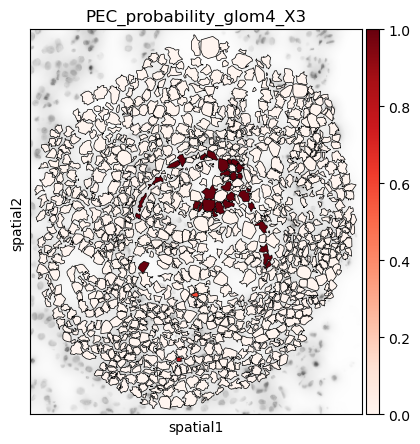

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))
slide_id = adata.obs['Slide_ID'][0]

adata.obs.loc[adata.obs['celltype_l1'] != 'PEC', 'celltype_l1_prob'] = 0

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = ['Ki67', 'dapi_LEVEL1_cropped',None][1],
              color = 'celltype_l1_prob',
              size = 0,
              ax = ax,
              cmap='Reds',
              title="PEC_probability_glom4_X3",
              show = False,
             )

ki67_values = adata.obs['celltype_l1_prob'].values
ki67_min, ki67_max = ki67_values.min(), ki67_values.max()
normalized_values = (ki67_values - ki67_min) / (ki67_max - ki67_min)
cmap = plt.get_cmap('Reds')
colors = [cmap(value) for value in normalized_values]

coords_all = np.array([]).reshape([0, 2])

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
    
    cell_name = idx.split('-')[1]
    coords = df_polygon_i.loc[cell_name, 'coords']

    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    coords_all = np.concatenate([coords_all, coords])

    polygon_obj = matplotlibPolygon(coords, 
                          facecolor=colors[n],
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5,
                         )


    ax.add_patch(polygon_obj)


i_min, j_min = coords_all.min(axis=0) - 5
i_max, j_max = coords_all.max(axis=0) + 5

ax.set_xlim(i_min, i_max)
ax.set_ylim(j_min, j_max)
ax.invert_yaxis()

plt.savefig("PEC_glom4_X3.pdf", bbox_inches="tight")
plt.show()

In [27]:
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,celltype_l1,celltype_l1_codes,celltype_l1_prob,Slide_ID,sample,label,is_in_polygon,nichepca_glom_no,polygon_id,cell_name
cell_CR9fbacb852-153170,7092.386232,13428.500780,28.385260,3,41,0.9942,1.732,41.24,0.9980,0.9527,...,EC,24,0.999669,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,153170
cell_CR9fbacb852-153199,7120.733177,13398.874577,27.631408,1,97,0.7717,1.286,125.70,0.9980,0.9468,...,PT,16,1.000000,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,153199
cell_CR9fbacb852-153204,7088.793197,13433.869169,27.803531,3,68,1.2230,2.425,55.62,0.9980,0.9379,...,DCT,3,0.999869,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,153204
cell_CR9fbacb852-153313,7086.772676,13441.781944,27.622785,3,71,1.5570,1.489,45.59,0.9982,0.8941,...,DCT,3,0.722969,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,153313
cell_CR9fbacb852-153320,7132.766611,13394.213656,28.405226,1,128,0.8127,1.413,157.50,0.9973,0.9294,...,PT,16,1.000000,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,153320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-342153,7156.616157,13617.036405,26.849579,4,42,2.4990,2.912,16.81,0.9976,0.7281,...,MAC,8,0.999960,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,342153
cell_CR9fbacb852-343670,7311.355078,13528.870703,27.418549,4,37,2.4330,3.143,15.21,0.9981,0.8011,...,FIB,6,1.000000,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,343670
cell_CR9fbacb852-343675,7359.627888,13536.367956,26.355797,4,34,1.6140,5.497,21.06,0.9982,0.6735,...,pDC,27,0.344557,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,343675
cell_CR9fbacb852-344224,7179.321350,13431.796125,25.942680,4,8,2.3740,3.489,3.37,0.9969,0.8900,...,T,18,0.928944,0011186,x3,anca,True,Other,4_0011186_ANCA_X3_slide2,344224
